Abschnitt [Model Checking](http://nbviewer.jupyter.org/github/markdregan/Bayesian-Modelling-in-Python/blob/master/Section%202.%20Model%20checking.ipynb) des Tutorials [Bayesian Modeling in Python](http://nbviewer.jupyter.org/github/markdregan/Bayesian-Modelling-in-Python/blob/master/Section%200.%20Introduction.ipynb).

# Diagnose via Posterior Predictive Check

In [4]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as stats
import statsmodels.api as sm
import theano.tensor as tt

from IPython.display import Image

%matplotlib inline
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

messages = pd.read_csv('data/hangout_chat_data.csv')

Modell schätzen (vgl [vorherigen Abschnitt](1-Estimate.ipynb))

In [11]:
with pm.Model() as model:
    mu = pm.Uniform('mu', lower=0, upper=100)
    y_est = pm.Poisson('y_est', mu=mu, observed=messages['time_delay_seconds'].values)

    y_pred = pm.Poisson('y_pred', mu=mu)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(200000, step, start=start, progressbar=True)

100%|██████████| 200000/200000 [00:27<00:00, 7253.04it/s]


Im _Posterior Predicitive Check_ Daten aus dem Modell entsprechend der Posterior-Verteilung der Parameterschätzer generieren und mit beobachteten Daten vergleichen.

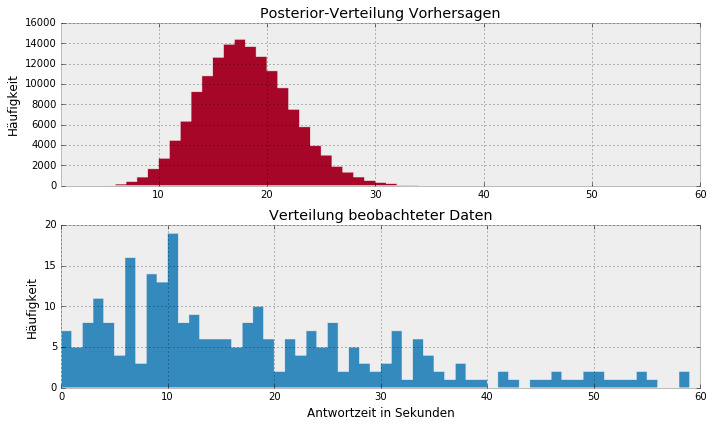

In [12]:
x_lim = 60
burnin = 50000

y_pred = trace[burnin:].get_values('y_pred')
mu_mean = trace[burnin:].get_values('mu').mean()

fig = plt.figure(figsize=(10,6))
fig.add_subplot(211)

_ = plt.hist(y_pred, range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])   
_ = plt.xlim(1, x_lim)
_ = plt.ylabel('Häufigkeit')
_ = plt.title('Posterior predictive distribution')

fig.add_subplot(212)

_ = plt.hist(messages['time_delay_seconds'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
_ = plt.xlabel('Antwortzeit in Sekunden')
_ = plt.ylabel('Häufigkeit')
_ = plt.title('Verteilung beobachteter Daten')

plt.tight_layout()

Verteilungen stimmen nicht gut überein. Negative Binomialverteilung als Alterative prüfen.

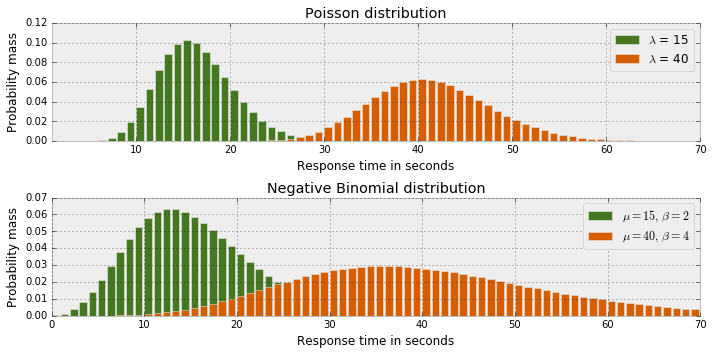

In [13]:
fig = plt.figure(figsize=(10,5))
fig.add_subplot(211)
x_lim = 70
mu = [15, 40]
for i in np.arange(x_lim):
    plt.bar(i, stats.poisson.pmf(mu[0], i), color=colors[3])
    plt.bar(i, stats.poisson.pmf(mu[1], i), color=colors[4])
    
_ = plt.xlim(1, x_lim)
_ = plt.xlabel('Response time in seconds')
_ = plt.ylabel('Probability mass')
_ = plt.title('Poisson distribution')
_ = plt.legend(['$\lambda$ = %s' % mu[0],
                '$\lambda$ = %s' % mu[1]])

# Scipy takes parameters n & p, not mu & alpha
def get_n(mu, alpha):
    return 1. / alpha * mu

def get_p(mu, alpha):
    return get_n(mu, alpha) / (get_n(mu, alpha) + mu)

fig.add_subplot(212)

a = [2, 4]

for i in np.arange(x_lim):
    plt.bar(i, stats.nbinom.pmf(i, n=get_n(mu[0], a[0]), p=get_p(mu[0], a[0])), color=colors[3])
    plt.bar(i, stats.nbinom.pmf(i, n=get_n(mu[1], a[1]), p=get_p(mu[1], a[1])), color=colors[4])

_ = plt.xlabel('Response time in seconds')
_ = plt.ylabel('Probability mass')
_ = plt.title('Negative Binomial distribution')
_ = plt.legend(['$\\mu = %s, \/ \\beta = %s$' % (mu[0], a[0]),
                '$\\mu = %s, \/ \\beta = %s$' % (mu[1], a[1])])

plt.tight_layout()

Annahme: Varianzparameter $\alpha$ Prior exponentialverteilt (kleine Varianzen viel wahrscheinlicher).

In [15]:
with pm.Model() as model:
    alpha = pm.Exponential('alpha', lam=.2)
    mu = pm.Uniform('mu', lower=0, upper=100)
    
    y_pred = pm.NegativeBinomial('y_pred', mu=mu, alpha=alpha)
    y_est = pm.NegativeBinomial('y_est', mu=mu, alpha=alpha, observed=messages['time_delay_seconds'].values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(200000, step, start=start, progressbar=True)

100%|██████████| 200000/200000 [01:00<00:00, 3323.07it/s]


$\mu $ Parameter größere Unsicherheit als im Poisson-Modell. Hoher Varianzparameter $\alpha $ vergrößert Varianz ebenfalls.

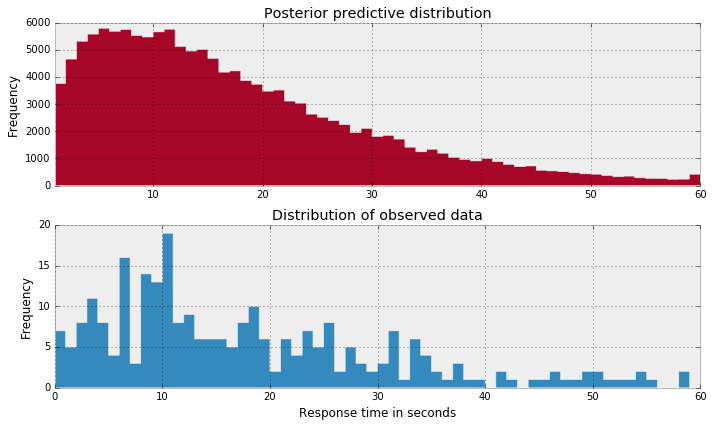

In [16]:
x_lim = 60
y_pred = trace[burnin:].get_values('y_pred')

fig = plt.figure(figsize=(10,6))
fig.add_subplot(211)

fig.add_subplot(211)

_ = plt.hist(y_pred, range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])   
_ = plt.xlim(1, x_lim)
_ = plt.ylabel('Frequency')
_ = plt.title('Posterior predictive distribution')

fig.add_subplot(212)

_ = plt.hist(messages['time_delay_seconds'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
_ = plt.xlabel('Response time in seconds')
_ = plt.ylabel('Frequency')
_ = plt.title('Distribution of observed data')

plt.tight_layout()

Fit nun viel besser. Negative Binomialverteilung besseres Modell.
# Diagnose via Bayes Factor

In [19]:
with pm.Model() as model:
    
    # Index to true model
    prior_model_prob = 0.5
    #tau = pm.DiscreteUniform('tau', lower=0, upper=1)
    tau = pm.Bernoulli('tau', prior_model_prob)
    
    # Poisson parameters
    mu_p = pm.Uniform('mu_p', 0, 60)

    # Negative Binomial parameters
    alpha = pm.Exponential('alpha', lam=0.2)
    mu_nb = pm.Uniform('mu_nb', lower=0, upper=60)

    y_like = pm.DensityDist('y_like',
             lambda value: pm.switch(tau, 
                 pm.Poisson.dist(mu_p).logp(value),
                 pm.NegativeBinomial.dist(mu_nb, alpha).logp(value)
             ),
             observed=messages['time_delay_seconds'].values)
"""    
    start = pm.find_MAP()
    step1 = pm.Metropolis([mu_p, alpha, mu_nb])
    step2 = pm.ElemwiseCategorical(vars=[tau], values=[0,1])
    trace = pm.sample(200000, step=[step1, step2], start=start)

_ = pm.traceplot(trace[burnin:], varnames=['tau'])
"""

AttributeError: module 'pymc3' has no attribute 'switch'